In [1]:
import copy
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.utils.data as data
import torchvision
import torchvision.transforms as transforms
import torchvision.datasets as Datasets

device = 'cuda' if torch.cuda.is_available() else "cpu"

In [2]:
class VGG(nn.Module):
    def __init__(self, features, output_dim):
        super(VGG, self).__init__()
        self.features = features
        self.avgpool = nn.AdaptiveAvgPool2d(7)
        self.classifier = nn.Sequential(
            nn.Linear(512*7*7, 4096),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(4096, 4096),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(4096, output_dim),
        )
        
    def forward(self, x):
        x = self.features(x)
        x = self.avgpool(x)
        x = x.view(x.shape[0], -1)
        x = self.classifier(x)
        return x

In [3]:
vgg11_config = [64, 'M', 128, 'M', 256, 256, 'M', 512, 512, 'M', 512, 512, 'M']

vgg13_config = [64, 64, 'M', 128, 128, 'M',
                256, 256, 'M', 512, 512, 'M', 512, 512, 'M']

vgg16_config = [64, 64, 'M', 128, 128, 'M', 256, 256, 256, 'M', 512, 512, 512, 'M', 512, 512,
                512, 'M']

vgg19_config = [64, 64, 'M', 128, 128, 'M', 256, 256, 256, 256, 'M', 512, 512, 512, 512, 'M',
                512, 512, 512, 512, 'M']

In [4]:
def get_vgg_layer(config, batch_norm):
    layer = []
    in_channels = 3
    
    for c in config:
        assert c == 'M' or isinstance(c, int)
        if c == 'M':
            layer += [nn.MaxPool2d(kernel_size=2)]
        else:
            conv2d = nn.Conv2d(in_channels, c, kernel_size=3, padding=1)
            if batch_norm:
                layer += [conv2d, nn.BatchNorm2d(c), nn.ReLU()]
            else:
                layer += [conv2d, nn.ReLU()]
            in_channels = c
            
    return nn.Sequential(*layer)

In [5]:
vgg11_layers = get_vgg_layer(vgg11_config, batch_norm = True)

In [6]:
print(vgg11_layers)

Sequential(
  (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): ReLU()
  (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (4): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (5): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (6): ReLU()
  (7): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (8): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (9): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (10): ReLU()
  (11): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (12): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (13): ReLU()
  (14): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (15): Conv2d(256, 512, kernel_si

In [7]:
output_dim = 2
model = VGG(vgg11_layers, output_dim)
print(model)

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (5): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU()
    (7): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (8): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): ReLU()
    (11): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (12): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (13): ReLU()
    (14): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ce

In [8]:
import torchvision.models as models
pretrained_vgg11 = models.vgg11_bn(pretrained = True)
print(pretrained_vgg11)

/opt/conda/lib/python3.11/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/conda/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG11_BN_Weights.IMAGENET1K_V1`. You can also use `weights=VGG11_BN_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (5): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU(inplace=True)
    (7): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (8): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): ReLU(inplace=True)
    (11): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (12): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (13): ReLU(inplace=True)
    (14): MaxPool2d(ke

In [9]:
train_transforms = transforms.Compose([
    transforms.Resize((256,256)),
    transforms.RandomRotation(5),
    transforms.RandomHorizontalFlip(0.5),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],std=[0.229, 0.224, 0.225])
])

test_transforms = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

In [10]:
train_path = './data/catanddog/train'
test_path = './data/catanddog/test'

train_dataset = torchvision.datasets.ImageFolder(
    train_path,
    transform = train_transforms
)
test_dataset= torchvision.datasets.ImageFolder(
    test_path,
    transform=test_transforms
)

print(len(train_dataset), len(test_dataset))

529 12


In [11]:
valid_ratio = 0.1
n_train_example = int(len(train_dataset) * (1 - valid_ratio))
n_valid_example = len(train_dataset) - n_train_example

train_data, valid_data = data.random_split(train_dataset,
                                           [n_train_example, n_valid_example,])

In [12]:
valid_data = copy.deepcopy(valid_data)
valid_data.dataset.transform = test_transforms

In [13]:
#이게 더 효율적인 거 같음
# import torchvision
# import torch
# from sklearn.model_selection import train_test_split
# from torchvision import transforms

# # 경로 설정
# train_path = './data/catanddog/train'

# # 1. transform 없이 전체 데이터셋을 불러옴 (개수만 파악하기 위함)
# dataset = torchvision.datasets.ImageFolder(train_path)

# # 2. train/validation 인덱스를 나눔
# train_indices, valid_indices = train_test_split(
#     range(len(dataset)), test_size=0.1)

# # 3. train/valid 데이터셋을 나눔
# train_data = torch.utils.data.Subset(dataset, train_indices)
# valid_data = torch.utils.data.Subset(dataset, valid_indices)

# # 4. 각각의 데이터셋에 transform을 나눠서 적용
# train_transforms = transforms.Compose([
#     transforms.Resize((256, 256)),
#     transforms.RandomRotation(5),
#     transforms.RandomHorizontalFlip(0.5),
#     transforms.ToTensor(),
#     transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
# ])

# test_transforms = transforms.Compose([
#     transforms.Resize((256, 256)),
#     transforms.ToTensor(),
#     transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
# ])

# # 각각의 데이터셋에 맞는 transform 적용
# train_data.dataset.transform = train_transforms
# valid_data.dataset.transform = test_transforms

# print(f"Train 데이터 개수: {len(train_data)}")
# print(f"Validation 데이터 개수: {len(valid_data)}")

In [14]:
print(f'Number of training examples: {len(train_data)}')
print(f'Number of validation examples: {len(valid_data)}')
print(f'Number of testing examples: {len(test_dataset)}')

Number of training examples: 476
Number of validation examples: 53
Number of testing examples: 12


In [15]:
batch_size = 32
train_iter = data.DataLoader(train_data, shuffle=True, batch_size=batch_size)
valid_iter = data.DataLoader(valid_data, batch_size=batch_size)
test_iter = data.DataLoader(test_dataset, batch_size=batch_size)

In [16]:
optim = optim.Adam(model.parameters(), lr = 1e-7)
criterion = nn.CrossEntropyLoss()

model = model.to(device)

In [17]:
def calculate_acc(pred, label):
    top_pred = pred.argmax(1, keepdim=True)
    corr = top_pred.eq(label.view_as(top_pred).to(device)).sum().item()
    acc = corr / label.shape[0]
    return acc

In [18]:
def train(model, iterator, optim, criterion, device):
    epoch_loss = 0
    epoch_acc = 0
    
    model.train()
    for (x, y) in iterator:
        optim.zero_grad()
        pred = model(x.to(device))
        loss = criterion(pred, y.to(device))
        acc = calculate_acc(pred, y)
        loss.backward()
        optim.step()
        
        epoch_loss += loss.item()
        epoch_acc += acc
    return epoch_loss / len(iterator), epoch_acc / len(iterator)

In [19]:
def evaluate(model, iterator, criterion, device):
    epoch_loss = 0
    epoch_acc = 0

    model.eval()
    with torch.no_grad():
        for (x, y) in iterator:
            x = x.to(device)
            y = y.to(device)
            y_pred = model(x)
            loss = criterion(y_pred, y)
            acc = calculate_acc(y_pred, y)
            epoch_loss += loss.item()
            epoch_acc += acc
    return epoch_loss / len(iterator), epoch_acc / len(iterator)

In [20]:
def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

In [21]:
import time
epoch = 5

best_valid_loss = float('inf')
for epoch in range(epoch):
    start_time = time.monotonic()
    train_loss, train_acc = train(model, train_iter, optim, criterion, device)
    valid_loss, valid_acc = evaluate(model, valid_iter, criterion, device)
    
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), './data/VGG-model.pt')
        
    end_time = time.monotonic()
    epoch_mins, epoch_secs = epoch_time(start_time, end_time)

    print(f'Epoch: {epoch+1:02} | Epoch Time: {epoch_mins}m {epoch_secs}s')
    print(f'\tTrain Loss: {train_loss:.3f} | Train Acc: {train_acc*100:.2f}%')
    print(f'\t Valid. Loss: {valid_loss:.3f} |  Valid. Acc: {valid_acc*100:.2f}%')
    

Epoch: 01 | Epoch Time: 0m 2s
	Train Loss: 0.694 | Train Acc: 49.61%
	 Valid. Loss: 0.692 |  Valid. Acc: 58.26%
Epoch: 02 | Epoch Time: 0m 2s
	Train Loss: 0.702 | Train Acc: 47.86%
	 Valid. Loss: 0.691 |  Valid. Acc: 55.88%
Epoch: 03 | Epoch Time: 0m 2s
	Train Loss: 0.706 | Train Acc: 46.10%
	 Valid. Loss: 0.685 |  Valid. Acc: 56.70%
Epoch: 04 | Epoch Time: 0m 2s
	Train Loss: 0.695 | Train Acc: 50.54%
	 Valid. Loss: 0.682 |  Valid. Acc: 55.06%
Epoch: 05 | Epoch Time: 0m 2s
	Train Loss: 0.693 | Train Acc: 52.62%
	 Valid. Loss: 0.679 |  Valid. Acc: 63.76%


In [22]:
model.load_state_dict(torch.load('./data/VGG-model.pt'))
test_loss, test_acc = evaluate(model, test_iter, criterion, device)
print(f'Test Loss: {test_loss:.3f} | Test Acc: {test_acc*100:.2f}%')

Test Loss: 0.680 | Test Acc: 58.33%


/tmp/ipykernel_587763/483280338.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('./data/VGG-model.pt'))


In [23]:
def get_predictions(model, iterator):
    model.eval()
    images = []
    labels = []
    probs = []

    with torch.no_grad():
        for (x, y) in iterator:
            x = x.to(device)
            y_pred = model(x)
            y_prob = F.softmax(y_pred, dim=-1)
            top_pred = y_prob.argmax(1, keepdim=True)
            images.append(x.cpu())
            labels.append(y.cpu())
            probs.append(y_prob.cpu())

    images = torch.cat(images, dim=0)
    labels = torch.cat(labels, dim=0)
    probs = torch.cat(probs, dim=0)
    return images, labels, probs

In [24]:
images, labels, probs = get_predictions(model, test_iter)
pred_labels = torch.argmax(probs, 1)
corrects = torch.eq(labels, pred_labels)
correct_examples = []

for image, label, prob, correct in zip(images, labels, probs, corrects):
    if correct:
        correct_examples.append((image, label, prob))

correct_examples.sort(
    reverse=True, key=lambda x: torch.max(x[2], dim=0).values)

In [25]:
def normalize_image(image):
    image_min = image.min()
    image_max = image.max()
    image.clamp_(min=image_min, max=image_max)
    image.add_(-image_min).div_(image_max - image_min + 1e-5)
    return image

In [26]:
import matplotlib.pyplot as plt

def plot_most_correct(correct, classes, n_images, normalize=True):
    rows = int(np.sqrt(n_images))
    cols = int(np.sqrt(n_images))
    fig = plt.figure(figsize=(25, 20))
    for i in range(rows*cols):
        ax = fig.add_subplot(rows, cols, i+1)
        image, true_label, probs = correct[i]
        image = image.permute(1, 2, 0)
        true_prob = probs[true_label]
        correct_prob, correct_label = torch.max(probs, dim=0)
        true_class = classes[true_label]
        correct_class = classes[correct_label]

        if normalize:
            image = normalize_image(image)

        ax.imshow(image.cpu().numpy())
        ax.set_title(f'true label: {true_class} ({true_prob:.3f})\n'
                     f'pred label: {correct_class} ({correct_prob:.3f})')
        ax.axis('off')

    fig.subplots_adjust(hspace=0.4)

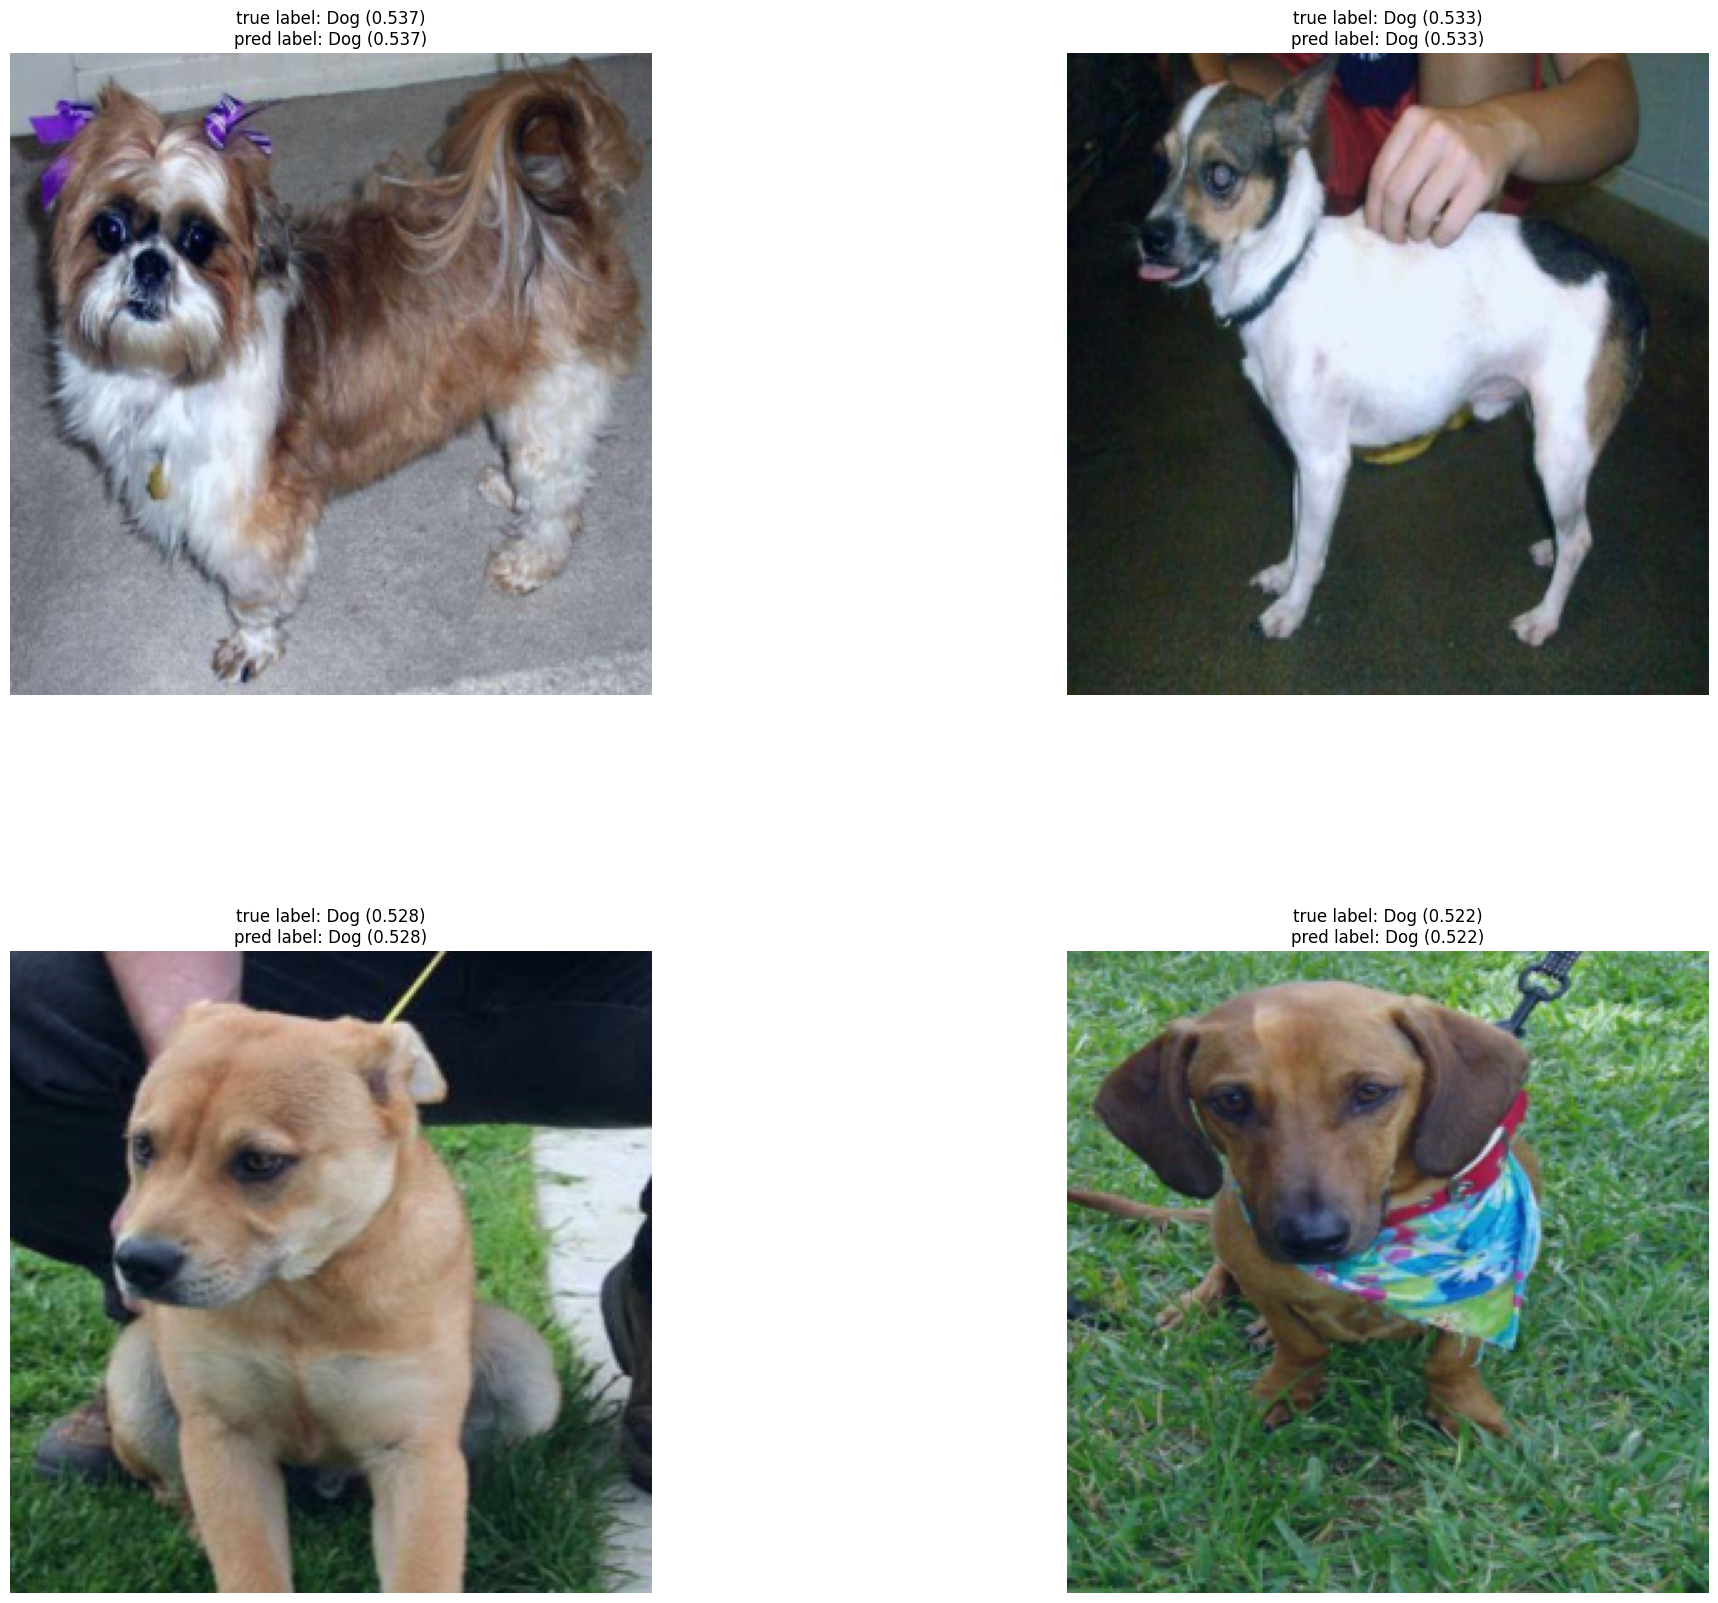

In [28]:
classes = test_dataset.classes
N_IMAGES = 5
plot_most_correct(correct_examples, classes, N_IMAGES)